In [1]:
load_all =  True #load directly from a pickle
pre_separated = False #if three subfolders already exist for train test and val

override = False #make this true to always use the same ones

extension = "_open_ht_lv"
number_of_messages = 2
size_of_messages = 64
absolute = 0
epochs = 361
distrib = "laplace"
aggr = "mean"

name_complete = extension + "_" + str(number_of_messages) + "_" + str(size_of_messages) + "_" + ("absolute" if absolute else "relative") + "_" + distrib + "_" + aggr

print(name_complete)

model_path = "models/model" + name_complete

_open_ht_lv_2_64_relative_laplace_mean


In [2]:
from cell_dataset import load
data_train, data_test, data_val = load(load_all, extension, pre_separated, override)

Validation data not found


In [4]:
from cell_model import Gatv2Predictor
from genericpath import exists
import torch

epoch_to_load = 200

model = Gatv2Predictor(in_channels=12, out_channels=4, hidden_channels=size_of_messages, dropout=0.05, edge_dim=2, messages=number_of_messages, wrap=data_train.wrap, absolute=absolute)

if exists(model_path + str(epoch_to_load) + ".pt") :
    model.load_state_dict(torch.load(model_path + str(epoch_to_load) + ".pt"))
    print("Loaded model")
else :
    raise Exception("Model not found")

Loaded model


In [10]:
from cell_training import predict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device) 
data_y, data_x = predict(model, data_test, device, -1, recursive=True, distrib=distrib)

In [11]:
#here we skip the first of the data because it has 0 speed and it makes the plot crash (1/0)
data_y = torch.cat((data_y[:,1:], data_y[:,1:,:,:] - data_y[:,:-1,:,:]), dim=3)
data_x = torch.cat((data_x[:,1:], data_x[:,1:,:,:] - data_x[:,:-1,:,:]), dim=3)

#here we skip the first of the data because it has 0 speed and it makes the plot crash (1/0)
data_y = data_y.cpu().numpy() #model
data_x = data_x.cpu().numpy() #data


In [12]:
from allium import SimData
import numpy as np

class Parameters(object):
    def __init__(self, p):
        for key, values in p.items():
            setattr(self, key, values)

class SyntheticData:
    @staticmethod
    def checkTypes(readtypes,data):
        #check which particles to load 
        if len(readtypes) > 0:
            usetypes = np.isin(data[:,-1],readtypes)
        else:
            usetypes = [True]*len(data)
        return usetypes

    # Data object for summary statistics
    def __init__(self,**kwargs):
        # check for debugging
        try:
            self.debug = kwargs['debug']
            if self.debug:
                print('kwargs: ', kwargs)
        except:
            self.debug = False
        # check for specific loadtimes
        try:    
            self.start = kwargs["loadtimes"][0]
            self.end = kwargs["loadtimes"][1]
            self.multiopt = True
        except:
            self.multiopt = False
        # check for specific types
        try:
            self.readtypes = kwargs["readtypes"]
        except:
            self.readtypes = []
            
        try:
            self.dt = kwargs["dt"]
        except:
            self.dt = 1
        # load parameters
        try:    
            self.param = Parameters(kwargs['params'])
        except Exception as e:
            print('Error! Parameters must be a dictionary', e)
            return 1
        # load multiple simulation snapshots
        self.Nsnap = self.end - self.start + 1
        #get maximum number of particles
        self.N = sum(SimData.checkTypes(self.readtypes, kwargs['data'][0]))
        self.Nvals = []
        self.Nvariable =  False
        for t in range(self.start,self.end):
            self.Nvals.append(sum(SimData.checkTypes(self.readtypes, kwargs['data'][t])))
            if self.Nvals[t] > self.N:
                self.N = self.Nvals[t] 
                self.Nvariable = True
        if kwargs['trackAll'] and self.Nvariable == False:
            self.Ntracers = self.Nvals[0]
        else:
            print('Error! Currently assuming tracking all cells')
        self.data = kwargs['data']
        self.flag = np.zeros((self.Nsnap,self.N))
        if self.data.shape[-1] == 5:
            self.Z = self.data[:,:,4]
        else:
            np.zeros((self.Nsnap,self.N))
            
        self.rval = self.data[:,:,:2]
        self.vval = self.data[:,:,2:4]
        self.theta = np.zeros((self.Nsnap,self.N))
        self.nval = np.zeros((self.Nsnap,self.N,2))
        self.radius = np.ones((self.Nsnap,self.N))
        self.ptype = np.ones((self.Nsnap,self.N))
        self.sigma = 0.
        
        return None

    def gettypes(self, readtypes, frames):
        return np.isin(self.ptype[frames],readtypes)

    def truncateto(self,start, endtime):
        self.Nsnap = endtime - start
        self.flag =  self.flag[start:endtime]
        self.rval = self.rval[start:endtime]
        self.vval = self.vval[start:endtime]
        self.theta = self.theta[start:endtime]
        self.nval = self.nval[start:endtime]
        self.radius = self.radius[start:endtime]
        self.ptype = self.ptype[start:endtime]
        self.Nvals = self.Nvals[start:endtime]
        self.Ntracers = self.Ntracers[start:endtime]


In [13]:
import json 
import allium.summstats as ss

configfile = "simconfig_open.json"

with open(configfile) as jsonFile:
    parameters = json.load(jsonFile)
    
vav_x = []
vdist_x = []
vdist2_x = []

vav_y = []
vdist_y = []
vdist2_y = []

msd_x = []
msd_y = []
    
velbins=np.linspace(0,5,100)
velbins2=np.linspace(-2,2,100)

    
for i in range(data_x.shape[0]):
    data_x_i = data_x[i]
    data_y_i = data_y[i]
    
    data_x_i_s = SyntheticData(loadtimes = [0,96], types = [0,1], debug = False, data = data_x_i, params = parameters, trackAll=True, dt = 1)
    data_y_i_s = SyntheticData(loadtimes = [0,96], types = [0,1], debug = False, data = data_y_i, params = parameters, trackAll=True, dt = 1)
    
    Nsnap  = data_x_i_s.Nsnap
    dt = data_x_i_s.param.dt
    output_time = data_x_i_s.param.output_time

    vav, vdist,vdist2 = ss.getVelDist(data_x_i_s, velbins,velbins2, usetype=[0,1],verbose=False)

    vdist = vdist[1:]
    vdist2 = vdist2[vdist2 != max(vdist2)]
    
    vav_x.append(vav)
    vdist_x.append(vdist)
    vdist2_x.append(vdist2)
    
    velbins=np.linspace(0,5,100)
    velbins2=np.linspace(-2,2,100)
    vav, vdist,vdist2 = ss.getVelDist(data_y_i_s, velbins,velbins2, usetype=[0,1],verbose=False)

    vdist = vdist[1:]
    vdist2 = vdist2[vdist2 != max(vdist2)]
    
    vav_y.append(vav)
    vdist_y.append(vdist)
    vdist2_y.append(vdist2)
    
    tval, msd, d = ss.getMSD(data_x_i_s, usetype=[1],verbose=False)
    
    msd_x.append(msd)
    
    tval, msd, d = ss.getMSD(data_y_i_s, usetype=[1],verbose=False)
    
    msd_y.append(msd)

4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


In [14]:
vav_x = np.array(vav_x)
vdist_x = np.array(vdist_x)
vdist2_x = np.array(vdist2_x)

vav_y = np.array(vav_y)
vdist_y = np.array(vdist_y)
vdist2_y = np.array(vdist2_y)

msd_x = np.array(msd_x)
msd_y = np.array(msd_y)

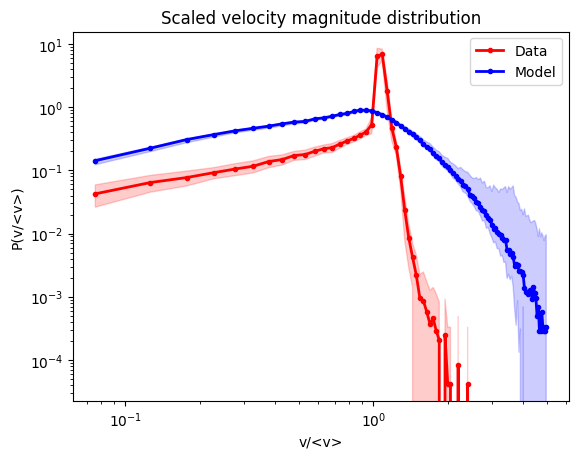

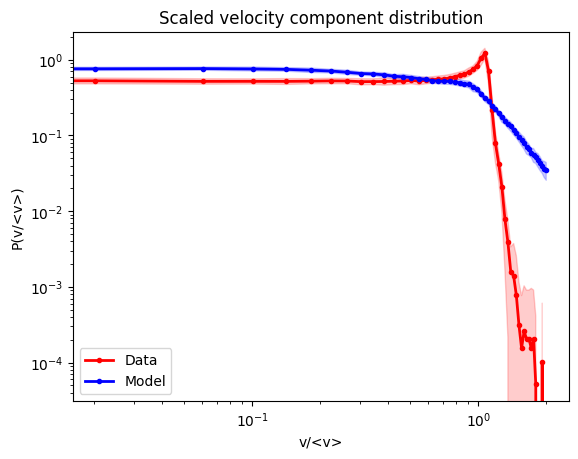

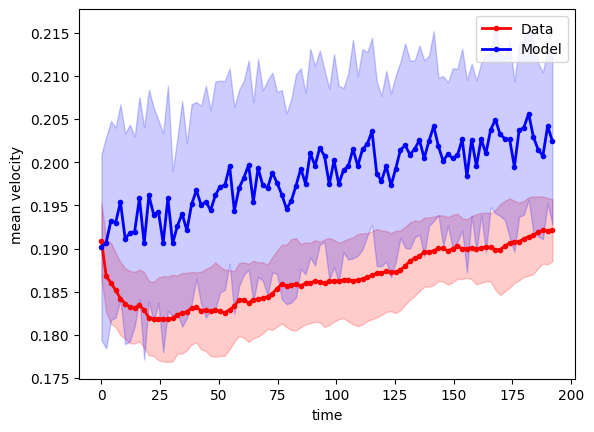

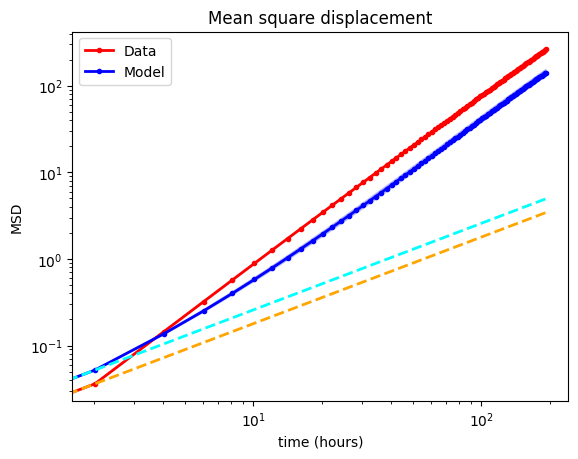

In [16]:
import matplotlib.pyplot as plt 

vav_x = np.array(vav_x)
vdist_x = np.array(vdist_x)
vdist2_x = np.array(vdist2_x)

vav_y = np.array(vav_y)
vdist_y = np.array(vdist_y)
vdist2_y = np.array(vdist2_y)

msd_x = np.array(msd_x)
msd_y = np.array(msd_y)

vdist_x_mean = np.mean(vdist_x, axis=0)
vdist_x_std = np.std(vdist_x, axis=0)

vdist2_x_mean = np.mean(vdist2_x, axis=0)
vdist2_x_std = np.std(vdist2_x, axis=0)

vav_x_mean = np.mean(vav_x, axis=0)
vav_x_std = np.std(vav_x, axis=0)

vdist_y_mean = np.mean(vdist_y, axis=0)
vdist_y_std = np.std(vdist_y, axis=0)

vdist2_y_mean = np.mean(vdist2_y, axis=0)
vdist2_y_std = np.std(vdist2_y, axis=0)

vav_y_mean = np.mean(vav_y, axis=0)
vav_y_std = np.std(vav_y, axis=0)

msd_x_mean = np.mean(msd_x, axis=0)
msd_x_std = np.std(msd_x, axis=0)

msd_y_mean = np.mean(msd_y, axis=0)
msd_y_std = np.std(msd_y, axis=0)

fig=plt.figure()
db=velbins[1]-velbins[0]
plt.semilogy(velbins[2:]-db/2,vdist_x_mean,'r.-',lw=2, label='Data')
plt.fill_between(velbins[2:]-db/2,vdist_x_mean+vdist_x_std,vdist_x_mean-vdist_x_std,color='r',alpha=0.2)
plt.semilogx(velbins[2:]-db/2,vdist_y_mean,'b.-',lw=2, label='Model')
plt.fill_between(velbins[2:]-db/2,vdist_y_mean+vdist2_y_std,vdist_y_mean-vdist_y_std,color='b',alpha=0.2)
plt.xlabel('v/<v>')
plt.ylabel('P(v/<v>)')
plt.title('Scaled velocity magnitude distribution')
plt.legend()
fig.savefig('svmd' + name_complete + '.pdf')

fig=plt.figure()
db=velbins2[1]-velbins2[0]
plt.semilogy(velbins2[2:],vdist2_x_mean,'r.-',lw=2, label='Data')
plt.fill_between(velbins2[2:],vdist2_x_mean+vdist2_x_std,vdist2_x_mean-vdist2_x_std,color='r',alpha=0.2)
plt.semilogx(velbins2[2:],vdist2_y_mean,'b.-',lw=2, label='Model')
plt.fill_between(velbins2[2:],vdist2_y_mean+vdist2_y_std,vdist2_y_mean-vdist2_y_std,color='b',alpha=0.2)
plt.xlabel('v/<v>')
plt.ylabel('P(v/<v>)')
plt.title('Scaled velocity component distribution')
plt.legend()
fig.savefig('svcd' + name_complete + '.pdf')

fig = plt.figure()
xval=np.linspace(0,(Nsnap-1)*dt*output_time,num=Nsnap-1)
plt.plot(xval,vav_x_mean,'r.-',lw=2, label='Data')
plt.fill_between(xval,vav_x_mean+vav_x_std,vav_x_mean-vav_x_std,color='r',alpha=0.2)
plt.plot(xval,vav_y_mean,'b.-',lw=2, label='Model')
plt.fill_between(xval,vav_y_mean+vav_y_std,vav_y_mean-vav_y_std,color='b',alpha=0.2)
plt.xlabel('time')
plt.ylabel('mean velocity')
plt.legend()
fig.savefig('mv' + name_complete + '.pdf')

fig=plt.figure()
plt.loglog(tval,msd_x_mean,'r.-',lw=2, label='Data')
plt.fill_between(tval,msd_x_mean+msd_x_std,msd_x_mean-msd_x_std,color='r',alpha=0.2)
plt.loglog(tval,msd_x_mean[1]/(1.0*tval[1])*tval,'--',lw=2,color="orange")
plt.loglog(tval,msd_y_mean,'b.-',lw=2, label='Model')
plt.fill_between(tval,msd_y_mean+msd_y_std,msd_y_mean-msd_y_std,color='b',alpha=0.2)
plt.loglog(tval,msd_y_mean[1]/(1.0*tval[1])*tval,'--',lw=2,color="cyan")
plt.xlabel('time (hours)')
plt.ylabel('MSD')
plt.title('Mean square displacement')
plt.legend()
fig.savefig('msd' + name_complete + '.pdf')